#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt 
import seaborn
from arch.univariate import GARCH , ConstantMean, Normal
import statsmodels.api as sm
from arch import arch_model
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#### Fetched all the data for the 3 selected stocks

In [2]:
start_date=dt.datetime(2000,1,1)
end_date=dt.datetime(2022, 3, 18)

tickers = ['PG', 'F', 'MSFT']

x=[]
for i in tickers:     
    r = web.DataReader(i, 'yahoo', start_date,end_date)     
    r['Ticker'] = i  
    r['log_ret']=np.log(r['Adj Close'])-np.log(r['Adj Close'].shift(1))
    r['log_ret']=r['log_ret'].fillna(0)
    x.append(r)

In [3]:
df = pd.concat(x)
df = df.reset_index()
df = df[['Date','Ticker','Adj Close','log_ret']]

In [4]:
df_log_ret=df.reset_index()
df_log_ret=df_log_ret.pivot('Date','Ticker','log_ret')
d=df_log_ret.index

In [5]:
df_log_ret

Ticker,F,MSFT,PG
Date,,,
2000-01-03,0.000000,0.000000,0.000000
2000-01-04,-0.033984,-0.034364,-0.019430
2000-01-05,0.003697,0.010489,-0.019208
2000-01-06,0.001229,-0.034072,0.045031
2000-01-07,0.071120,0.012983,0.076918
...,...,...,...
2022-03-14,-0.018880,-0.013046,0.012697
2022-03-15,0.020126,0.038011,0.035355
2022-03-16,0.031865,0.024901,-0.003400


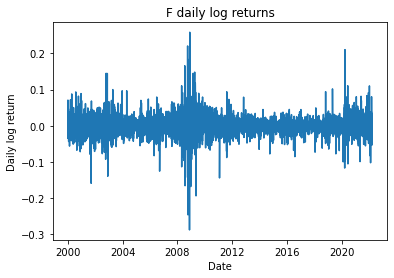

Descriptive statistic table for F
count    5589.000000
mean        0.000015
std         0.026585
min        -0.287682
25%        -0.012095
50%         0.000000
75%         0.011717
max         0.258650
Name: F, dtype: float64




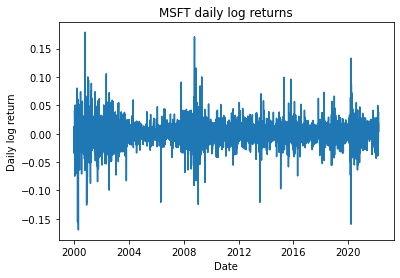

Descriptive statistic table for MSFT
count    5589.000000
mean        0.000376
std         0.019267
min        -0.169577
25%        -0.008128
50%         0.000357
75%         0.009212
max         0.178691
Name: MSFT, dtype: float64




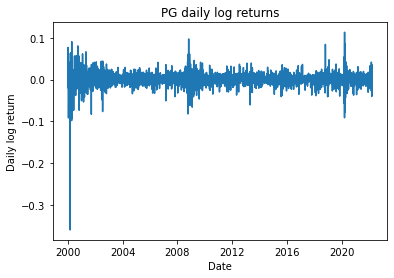

Descriptive statistic table for PG
count    5589.000000
mean        0.000290
std         0.013641
min        -0.360051
25%        -0.005267
50%         0.000369
75%         0.006103
max         0.113410
Name: PG, dtype: float64




In [6]:
for i in df_log_ret:
    plt.plot(df_log_ret.index, df_log_ret[i].values)
    plt.title(i+' daily log returns')
    plt.xlabel('Date')
    plt.ylabel('Daily log return')
    plt.show()
    print('Descriptive statistic table for '+i)
    print(df_log_ret[i].describe())
    print('\n')

#### Computed the unconditional correlation matrix

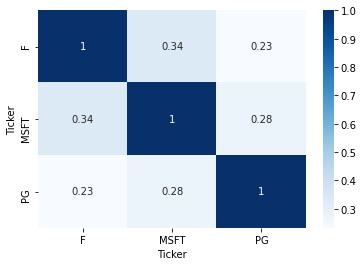

In [7]:
corr_df = df_log_ret.corr(method='pearson')
seaborn.heatmap(corr_df, annot=True, cmap='Blues')

#### Estimated the univariate GARCH model on the full sample with a normal innovation density

By checking the estimation, we noticed that all the parameters have a p-value lower than 1%, so we can reject H0(parameter=0).

Optimization terminated successfully    (Exit mode 0)
            Current function value: -13419.908389695927
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
GARCH(1,1) model for: F


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                13419.9
Distribution:                  Normal   AIC:                          -26833.8
Method:            Maximum Likelihood   BIC:                          -26813.9
                                        No. Observations:                 5589
Date:                Thu, Mar 24 2022   Df Residuals:                     5589
Time:                        19:51:45   Df Model:                            0
                              Volatility Model         

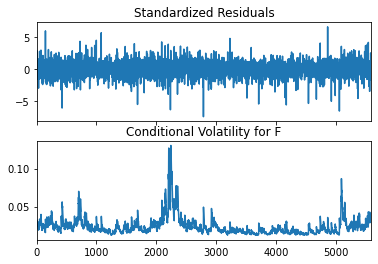

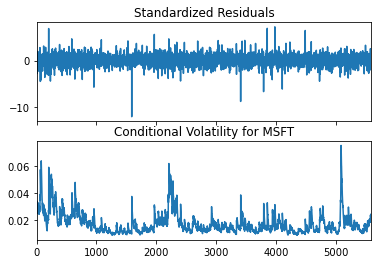

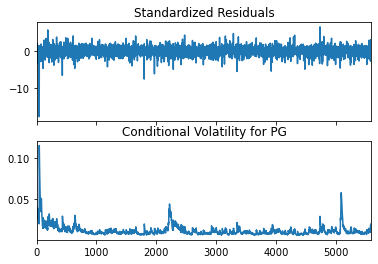

In [10]:
cond_vol=[]
for i in range(0,3):
    am = arch_model(np.ascontiguousarray(df_log_ret.iloc[:,i]), mean = 'Zero', vol='Garch', p=1, o=0, q=1, dist='Normal', rescale=False)
    resid = am.fit(update_freq=5)
    print('\033[1m' + "GARCH(1,1) model for: "+df_log_ret.iloc[:,i].name+ '\033[0m')
    print("\n")
    print(resid.summary())
    resid.plot()
    plt.title('Conditional Volatility for ' +str(df_log_ret.iloc[:,i].name))
    print("\n")
    print("\n")
    cond_vol.append(resid.conditional_volatility)

In [11]:
conditional_vol=pd.DataFrame({'F': cond_vol[0], 'MSFT': cond_vol[1],'PG': cond_vol[2]}).set_index(d)

#### Estimated the Dynamic Conditional Correlation (DCC) model with univariate GARCH

In [13]:
def vecl(matrix):
    lower_matrix = np.tril(matrix,k=-1)
    array_with_zero = np.matrix(lower_matrix).A1

    array_without_zero = array_with_zero[array_with_zero!=0]

    return array_without_zero

def garch_t_to_u(rets, res):
    mu = res.params['mu']
    nu = res.params['nu']
    est_r = rets - mu
    h = res.conditional_volatility
    std_res = est_r / h
    udata = t.cdf(std_res, nu)
    return udata

def loglike_norm_dcc_copula(theta, udata):
    N, T = np.shape(udata)
    llf = np.zeros((T,1))
    trdata = np.array(norm.ppf(udata).T, ndmin=2)
    
    
    Rt, veclRt =  dcceq(theta,trdata)

    for i in range(0,T):
        llf[i] = -0.5* np.log(np.linalg.det(Rt[:,:,i]))
        llf[i] = llf[i] - 0.5 *  np.matmul(np.matmul(trdata[i,:] , (np.linalg.inv(Rt[:,:,i]) - np.eye(N))) ,trdata[i,:].T)
    llf = np.sum(llf)

    return -llf

def dcceq(theta,trdata):
    T, N = np.shape(trdata)

    a, b = theta
    
    if min(a,b)<0 or max(a,b)>1 or a+b > .999999:
        a = .9999 - b
        
    Qt = np.zeros((N, N ,T))

    Qt[:,:,0] = np.cov(trdata.T)

    Rt =  np.zeros((N, N ,T))
    veclRt =  np.zeros((T, int(N*(N-1)/2)))
    
    Rt[:,:,0] = np.corrcoef(trdata.T)
    
    for j in range(1,T):
        Qt[:,:,j] = Qt[:,:,0] * (1-a-b)
        Qt[:,:,j] = Qt[:,:,j] + a * np.matmul(trdata[[j-1]].T, trdata[[j-1]])
        Qt[:,:,j] = Qt[:,:,j] + b * Qt[:,:,j-1]
        Rt[:,:,j] = np.divide(Qt[:,:,j] , np.matmul(np.sqrt(np.array(np.diag(Qt[:,:,j]), ndmin=2)).T , np.sqrt(np.array(np.diag(Qt[:,:,j]), ndmin=2))))
    
    for j in range(0,T):
        veclRt[j, :] = vecl(Rt[:,:,j].T)
    return Rt, veclRt


model_parameters = {}
udata_list = []

def run_garch_on_return(rets, udata_list, model_parameters):
    for x in rets:
        am = arch_model(rets[x], dist = 't')
        short_name = x.split()[0]
        model_parameters[short_name] = am.fit(disp='off')
        udata = garch_t_to_u(rets[x], model_parameters[short_name])
        udata_list.append(udata)
    return udata_list, model_parameters


udata_list, model_parameters = run_garch_on_return(df_log_ret*100, udata_list, model_parameters)

cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
bnds = ((0, 0.5), (0, 0.9997))

%time opt_out = minimize(loglike_norm_dcc_copula, [0.01, 0.95], args = (udata_list,), bounds=bnds, constraints=cons)


CPU times: user 31.6 s, sys: 2.18 s, total: 33.8 s
Wall time: 26.7 s


Here below we have the estimation of alpha (0.033) and beta (0.966)

In [14]:
print(opt_out.x)

[0.03316822 0.96683178]


In [15]:
trdata = np.array(norm.ppf(udata_list).T, ndmin=2)
Rt, veclRt = dcceq(opt_out.x, trdata)

In [16]:
stock_names = [x.split()[0] for x in df_log_ret.iloc[1:,:].columns]


corr_name_list = []
for i, name_a in enumerate(stock_names):
    if i == 0:
        pass
    else:
        for name_b in stock_names[:i]:
            corr_name_list.append(name_a + "-" + name_b)

#### Plotted the pairwise estimated variances from the GARCH model and the conditional correlation estimated with the DCC model

In [17]:
dcc_corr = pd.DataFrame(veclRt, index = df_log_ret.iloc[:,1:].index, columns= corr_name_list)

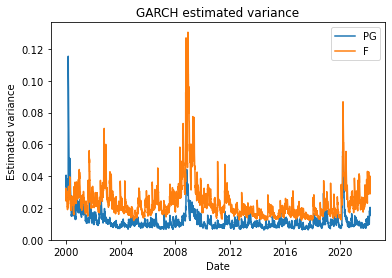

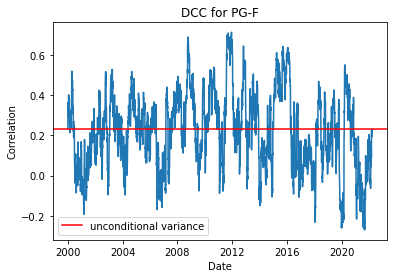

In [18]:
#PG-F
x=conditional_vol.index
y_PG=conditional_vol['PG']
y_F=conditional_vol['F']
plt.plot(x,y_PG, label='PG')
plt.plot(x,y_F, label='F')
plt.title('GARCH estimated variance')
plt.xlabel('Date')
plt.ylabel('Estimated variance')
plt.legend()
plt.show()

plt.plot(dcc_corr['PG-F'])
plt.axhline(y=corr_df.loc['F','PG'],color='r',linestyle='-', label='unconditional variance')
plt.title('DCC for PG-F')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()

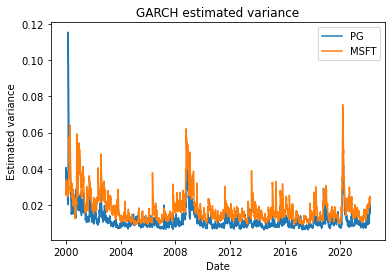

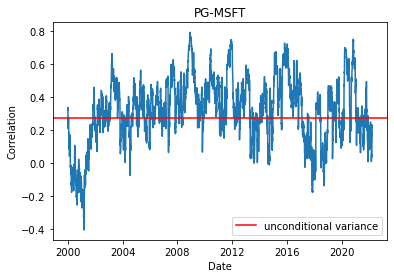

In [19]:
#PG-MSFT
y_PG=conditional_vol['PG']
y_MSFT=conditional_vol['MSFT']
x=conditional_vol.index
plt.plot(x,y_PG, label='PG')
plt.plot(x,y_MSFT, label='MSFT')
plt.title('GARCH estimated variance')
plt.xlabel('Date')
plt.ylabel('Estimated variance')
plt.legend()
plt.show()

plt.plot(dcc_corr['PG-MSFT'])
plt.axhline(y=corr_df.loc['MSFT','PG'],color='r',linestyle='-',label='unconditional variance')
plt.title('PG-MSFT')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()

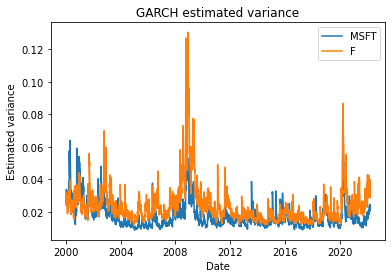

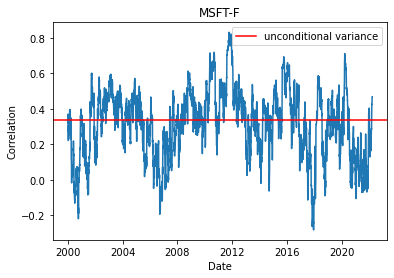

In [20]:
#MSFT-F
y_MSFT=conditional_vol['MSFT']
y_F=conditional_vol['F']
x=conditional_vol.index
plt.plot(x,y_MSFT, label='MSFT')
plt.plot(x,y_F, label='F')
plt.title('GARCH estimated variance')
plt.xlabel('Date')
plt.ylabel('Estimated variance')
plt.legend()
plt.show()

plt.plot(dcc_corr['MSFT-F'])
plt.axhline(y=corr_df.loc['MSFT','F'],color='r',linestyle='-',label='unconditional variance')
plt.title('MSFT-F')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()